# 🚀 Motion Classifier Tutorial: Data Labeling with Snorkel

In this tutorial, we will walk through the process of using Snorkel to build a training set for classifying court docket entries as MOTION or NOT MOTION.

Resources:
* For an overview of Snorkel, visit [snorkel.org](https://snorkel.org)
* You can also check out the [Snorkel API documentation](https://snorkel.readthedocs.io/)
* For some real-world applications, check out [Snorkel Applications](https://www.snorkel.org/resources/)
* Why does this work? See [Data Programming: Creating Large Training Sets, Quickly](https://arxiv.org/abs/1605.07723)
* Snorkel paper: [Snorkel: Rapid Training Data Creation with Weak Supervision](https://arxiv.org/abs/1711.10160)

The goal of this tutorial is to illustrate some basic components and concepts of Snorkel in a simple way, but also to dive into a process of iteratively developing a text classifier in Snorkel.

**The goal of this research is to design an interaction for a non-technical, domain expert to quickly label a dataset.**

To achieve this goal, we start with a basic task: *binary text classification* of court docket entries as MOTION or NOT MOTION.

We have access to a large amount of *unlabeled data* (about 1 300 000 samples) in the form of court docket entries with some metadata. We also have access to about *7000 labeled samples*.

In order to train a classifier, we need to label our data, but doing so by hand for real world applications can often be prohibitively slow and expensive.

In these cases, we can turn to a _weak supervision_ approach, using **_labeling functions (LFs)_** in Snorkel: noisy, programmatic rules and heuristics that assign labels to unlabeled training data.

We'll dive into the Snorkel API and how we write labeling functions later in this tutorial, but as an example, we can write an LF that labels data points with `"MOTION to"` in the docket entry text as MOTION since many motions contain `"MOTION to"`:

```python
from snorkel.labeling import labeling_function

@labeling_function()
def lf_contains_link(x):
    # Return a label of MOTION if "MOTION to" in comment text, otherwise ABSTAIN
    return MOTION if "motion to" in x.text.lower() else ABSTAIN
```

The tutorial is divided into four parts:
1. **Loading Data**: We load a US courts docket entries dataset, originally used in ["From data to information: automating data science to explore the U.S. court system"](https://dl.acm.org/doi/abs/10.1145/3462757.3466100).

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, and third-party models.

3. **Combining Labeling Function Outputs with the Label Model**: We model the outputs of the labeling functions over the training set using a Snorkel's, theoretically-grounded modeling approach, ["Data Programming:
Creating Large Training Sets, Quickly"](https://arxiv.org/abs/1605.07723), which estimates the accuracies and correlations of the labeling functions using only their agreements and disagreements, and then uses this to reweight and combine their outputs, which we then use as _probabilistic_ training labels.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* court docket entry (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

In future work, we'll consider *multiclass text classification* of court docket entries as MOTION type. Multiclass text classication is an important problem to work on because we need to define a process that is robust to *concept drift*. The set of classes could expand or change over time, and we do not want to start the labeling process from scratch.

**Note that this process requires programming, but out target user is not technical.**

If we are successful in these text classification tasks, we will consider  solutions to help non-technical workers label the data without programming themselves. Solutions include:
1. Function building interfaces, as seen on Snorkel Flow.
2. Distant supervision: leveraging external knowledge bases. 
3. Mapping natural language inputs to labeling functions. We can use the [BabbleLabbleFramework](https://github.com/HazyResearch/babble) to parse Snorkel Labeling Functions

<img src="images/BabbleLabble.png" alt="drawing" width="25%"/> 

4. Interfaces/systems where users can provide annotations, which are then converted to labeling functions. An example of such a technology is [Ruler: Data Programming by Demonstration for Document Labeling](https://aclanthology.org/2020.findings-emnlp.181/)

<img src="images/Ruler__Labeling_Interaction.png" alt="drawing" width="25%"/> 

We are also interested in optimizations of the interaction between the user and the system. An example is given by [Ruler: Data Programming by Demonstration for Document Labeling](https://aclanthology.org/2020.findings-emnlp.181/) below:

<img src="images/Ruler__DPBD.png" alt="drawing" width="25%"/> 

Some other important questions, raised by [Mallinar et al. 2019](https://arxiv.org/pdf/1812.06176.pdf):
1. How do we provide guidance to users to create effective labeling functions? From [Mallinar et al. 2019](https://arxiv.org/pdf/1812.06176.pdf), users desire guidance on how to optimize for precision, coverage, and bias between positive/negative examples in creating functions.
2. How do we support data exploration? Users may be domain experts, but that does not mean they are familiar with the corpus.
3. How do we provide fast feedback and progress tracking? Users desire to see how each query or labeling function impacts the results with immediate feedback. The feedback can help users actively adjust the labeling functions they provided. Systems that require training on many classes stress the need to know when it's time to move on to a diferent class.
4. How do we support evolving classes? (A framework like Snorkel can do this.)

Other questions:
1. How do we minimize the number of samples the user has to see or label?
2. Can we use active learning, uncertainty sampling, or other techniques to surface *valuable examples*? [Active WeaSuL: Improving Weak Supervision with Active Learning](https://github.com/SamanthaBiegel/ActiveWeaSuL) provides some ideas on this.
3. Can a system learn or define heuristics for data labeling? For instance in [Interactive Weak Supervision: Learning Useful Heuristics for Data Labeling](https://github.com/benbo/interactive-weak-supervision)

<img src="images/Interactive_weak_supervision.png" alt="drawing" width="50%"/> 

Note: For 3. how do we come up with the LF function family? Can it come from [Reef](https://github.com/HazyResearch/reef)? 

# The code starts here

## Imports

In [18]:
import re
import numpy as np
import pandas as pd

import metal
import snorkel
from snorkel.labeling import labeling_function, LabelingFunction, PandasLFApplier, LFAnalysis
from snorkel.labeling.model.label_model import LabelModel
from snorkel.labeling.model.baselines import MajorityClassVoter
from snorkel.labeling.model.baselines import MajorityLabelVoter

import spacy
from spacy import displacy
from spacy.lang.en import English

from sklearn.model_selection import train_test_split

Set `DISPLAY_FULL_TEXT` to `True` if you want to see the full docket entry texts.

In [19]:
DISPLAY_FULL_TEXT = True
pd.set_option('display.max_colwidth', 0 if DISPLAY_FULL_TEXT else 50)

## 1. Loading Data

In [20]:
data_dir = 'datasets/court_docket_entries'

We have 5 files:
1. `motionEntries.csv`: 1 300 000 docket entries, almost all unlabeled, with `text` and `id`
2. `tags.csv`: a mapping from `tag_id` to `label`, which is `motion class`
3. `thingy.csv`: looks like we can ignore this
4. `users.csv`: the annotators
5. `usertags`: 7 000 annotations for the docket entries with `docket_entry_id` and `tag_id`

In [21]:
# thingy = pd.read_csv(f"{data_dir}/thingy.csv")
# users = pd.read_csv(f"{data_dir}/users.csv")

We load the data from `motionEntries.csv`, `tags.csv`, and `usertags.csv`, rename some columns, and merge the data into one dataframe.

In [22]:
entries = pd.read_csv(f"{data_dir}/motionEntries.csv")
entries_columns = ['id', 'text', 'case_id', 'sealed', 'jurisdiction']
entries = entries[entries_columns].rename(columns={"id": "docket_entry_id"})

In [23]:
print(f"We have {entries.shape[0]} docket entries")

We have 1377516 docket entries


In [24]:
tags = pd.read_csv(f"{data_dir}/tags.csv")
# tags_columns = ['id', 'label', 'count']
tags_columns = ['id', 'label']
tags = tags[tags_columns].rename(columns={'id': 'tag_id'})
tags['motion'] = tags['tag_id'].apply(lambda x: int(x not in [26, 28]))

In [25]:
usertags = pd.read_csv(f"{data_dir}/usertags.csv")
usertags_columns = ['id', 'docket_entry_id', 'tag_id']
usertags = usertags[usertags_columns].rename(columns={'id': 'usertags_id'})

In [26]:
print(f"We have {usertags.shape[0]} labeled docket entries")

We have 7990 labeled docket entries


We merge the dataframes to get the text and motion label for each docket entry. Also, we remove the samples with label 'SKIP' because we don't know what to do with them.

In [27]:
labels = pd.merge(usertags, tags, on='tag_id')
labeled_motions = pd.merge(labels, entries, on='docket_entry_id')
labeled_motions = labeled_motions[labeled_motions['label'] != 'SKIP']
print(f"We have {labeled_motions.shape[0]} labeled docket entries when we remove SKIP.")

We have 6610 labeled docket entries when we remove SKIP.


Let's now create our dataset of labeled functions. We have 6610 samples if we remove the docket entries with label 'SKIP'.

In [28]:
keep_columns = ['docket_entry_id', 'motion', 'text']
lf_set = labeled_motions[keep_columns]

In [29]:
lf_set.head()

,docket_entry_id,motion,text
1,3112,1,"MOTION (Oral) by USA for excludable time from 9/18/07 through and including 10/04/07 pursuant to 18 USC 3161(h)(1) & (h)((1)(F) as to Demario Flemming (jmm-r, ) (Entered: 09/20/2007)"
4,9574,0,"DECLARATION of Aref Abdellatif regarding order on motion to compel,,,,,,, text entry,,,,,, 186 (Schaller, Rachel) (Entered: 08/19/2019)"
5,9574,0,"DECLARATION of Aref Abdellatif regarding order on motion to compel,,,,,,, text entry,,,,,, 186 (Schaller, Rachel) (Entered: 08/19/2019)"
9,4068,1,"MOTION by Tori Frederick DEFENDANT'S MOTION FOR PRETRIAL RELEASE (Rodriguez, Sergio) (Entered: 02/15/2008)"
11,833,1,"(Unopposed) NOTICE of Motion by Kathryn Ann Kelly for presentment of motion for leave to file excess pages 44 before Honorable M. David Weisman on 10/26/2017 at 09:15 AM. (Kelly, Kathryn) (Entered: 10/23/2017)"


Create train, dev, test split: 60/20/20.

In [231]:
# SPLIT_1 = 0.4
SPLIT_1 = 0.4
# SPLIT_2 = 0.5

In [232]:
df_train, df_test = train_test_split(lf_set, stratify=lf_set['motion'], test_size=SPLIT_1)
df_val, df_test = train_test_split(df_test, stratify=df_test['motion'], test_size=0.5)

In [233]:
def get_n_samples(df, n):
    return df.sample(n)

Let's set out voting values. Recall that the classification task is MOTION or NOT MOTION.

In [234]:
# Set voting values.
ABSTAIN = -1 
MOTION = 1 
NOT_MOTION = 0

In [235]:
get_n_samples(df_train, 20)

,docket_entry_id,motion,text
4383,13035,0,ENTRY for Magistrate Judge Susan Collins: 22 Dft's Unopposed Motion for First Enlargement of Time is granted. The Social Security Response Brief of the Government is due by 8/29/2016. The Social Security Reply Brief of the Plaintiff is due by 9/12/2016. So Ordered. (mr) (Entered: 07/29/2016)
2237,14287,1,"First MOTION for Extension of Time to File Response/Reply as to Set Deadlines, by Plaintiff Anchor Health Systems Inc. (O'Hara, Jonathan) (Entered: 04/02/2019)"
2073,2683,1,"MOTION by Defendants Richmond, City of Country Club Hills for extension of time to complete discovery (Attachments: # 1 Notice of Filing, # 2 Certificate of Service)(Kaplan, Brian) (Entered: 11/21/2008)"
1155,4725,0,"AFFIDAVIT ACCOMPANYING MOTION by Defendant Joseph Donelson for leave to appeal in forma pauperis (ks, ) (Entered: 12/05/2014)"
1783,3678,1,"MOTION by Plaintiffs Rabbi Dov Hillel Klein, Lubavitch-Chabad of Evanston, Inc., Lubavitch-Chabad of Illinois, Inc for extension of time to complete discovery , MOTION by Plaintiffs Rabbi Dov Hillel Klein, Lubavitch-Chabad of Evanston, Inc., Lubavitch-Chabad of Illinois, Inc for extension of time to file response/reply (Lubin, Jonathan) (Entered: 10/15/2013)"
4516,14989,0,"OPINION AND ORDER DENYING 3381 Executive Committee's motion to exclude opinions and testimony of Biomet's expert Steven R. Schmid; GRANTING IN PART AND DENYING IN PART 3382 the Executive Committee's motion to exclude opinions and testimony of Biomet expert David Schroeder; DENYING 3383 the Executive Committee's motion to exclude opinions and testimony of Biomet's expert Daniel Schultz, M.D.; GRANTING IN PART AND DENYING IN PART 3384 the Executive Committee's motion to exclude opinions and testimony of Biomet's expert Andrew I Spitzer, M.D.; GRANTING IN PART AND DENYING IN PART 3385 the Executive Committee's Motion to exclude opinions and testimony of Biomet's expert Dr. Kenneth St. John; DENYING 3386 Biomet's motion to exclude opinions and testimony of the plaintiffs' expert Mari Truman; GRANTING IN PART AND DENYING IN PART 3399 Biomet's motion to exclude opinions and testimony of the plaintiffs' expert George S Kantor, M.D. Associated Cases: 3:12-md-02391-RLM-MGG et al.(jld) (Entered: 12/22/2017)"
2997,2289,1,"MOTION for Leave to Appear Pro Hac Vice Filing fee $ 50, receipt number 0752-9077460. by Chuck H. Jew (Cascio, Anthony) (Entered: 01/07/2014)"
995,8958,0,"MOTION by Plaintiffs Carpenters Pension Fund of Illinois, Carpenters Retirement Savings Fund of Illinois for judgment (Ryan, Patrick) (Entered: 12/29/2015)"
1057,16278,0,"*WITHDRAWN per 55 ORDER* MOTION by Air Tech of Michigan, Inc. Defendant's Verified Motion to Recover Fees and Expenses (Attachments: # 1 Exhibit 1, # 2 Exhibit 2, # 3 Exhibit 3, # 4 Exhibit 4, # 5 Exhibit 5, # 6 Exhibit 6, # 7 Exhibit 7)(Miller, Andrew) Modified on 1/8/2018 to change event from notice to motion to be ruled on, per chambers. (lhc) Modified on 1/16/2018 (jss). (Entered: 01/05/2018)"
3666,2676,1,"MOTION by Defendant City of Country Club Hills to dismiss plaintiff's complaint pursuant to federal rule of civil procedure 12(b)(6). (vcf, ) (Entered: 05/16/2008)"


In [236]:
get_n_samples(df_train[df_train.motion == 0], 20)

,docket_entry_id,motion,text
4733,17396,0,"Amended NOTICE of Motion by Kenya A Jenkins for presentment of motion for protective order 41 before Honorable Matthew F. Kennelly on 11/17/2009 at 09:30 AM. (Jenkins, Kenya) (Entered: 11/16/2009)"
3323,207,0,"Joint NOTICE of Motion by Gail Lynne Reich for presentment of motion to dismiss 18 before Honorable Harry D. Leinenweber on 7/7/2009 at 09:30 AM. (Reich, Gail) (Entered: 06/30/2009)"
4615,5312,0,"AMENDED JUDGMENT as to Heidi L. Friedburg (1): Correction of sentencing by sentencing court (Fed.R.Crim.P.35(a): Any and all pending counts are dismissed on the motion of the United States. Upon release from imprisonment, the defendant shall be on supervised release for a term of: three(3) years. (Attachment). Signed by the Honorable Matthew F. Kennelly on 3/14/2011. Mailed copy to counsel of record (yap, ) Modified on 3/31/2011 (yap, ). (Entered: 03/16/2011)"
244,9595,0,"CERTIFICATE of Service regarding MOTION by Miguel Villanueva-Hernandez to supplement sentencing position paper 20 (Bischoff, Jerry) (Entered: 03/26/2008)"
3798,4315,0,"JUDGMENT (Sentencing Order) as to Martin Jiminez-Ponce (1), Count(s) 1s, The defendant pleaded guilty to count(s) 1 of the superseding criminal indictment. Count(s) of the original Indictment dismissed on the motion of the United States. The defendant is hereby committed to the custody of the United States Bureau of Prisons to be imprisoned for a total term of: Thirty (30) months. The defendant is remanded to the custody of the United States Marshal. Criminal Monetary Penalties. Schedule of Payments., (Terminated defendant Martin Jiminez-Ponce). Signed by the Honorable Robert W. Gettleman on 12/19/2017. Mailed certified copy to the defendant Martin Jimenez-Ponce's counsel of record Daniel J. Hesler. Mailed notice (mc, ) (Entered: 12/19/2017)"
4429,14564,0,"STATUS CONFERENCE held on 3/6/2017 before Magistrate Judge Susan L Collins. Pla appeared pro se. Dfts appeared by attys Benjamin Jones, Robert Keen, and Michael Brown. For reasons stated on the record, discovery remains open on subject matter jurisdiction. Pla anticipates filing motion for hearing on pending motions. Status Conference set for 4/13/2017 10:00 AM in US District Court - Fort Wayne before Magistrate Judge Susan L Collins. (cc: Plaintiff) (FTR 1st floor.) (mr) (Entered: 03/06/2017)"
4750,12100,0,"TELEPHONIC RULE 16 PRELIMINARY PRETRIAL CONFERENCE held on 2/2/2017 before Magistrate Judge Susan L Collins. Pla appeared by atty Lori Jansen. Dfts appeared by atty Spencer Feighner. The 31 Report of the Parties Planning Meeting is approved in all respects (except dispositive motions deadline and establishment of a trial date) and is hereby made an ORDER of the Court. The Summary Judgment deadline in Fed.R.Civ.P. 56(b) SHALL NOT control. Any dispositive motion SHALL brief out in accordance with L.R. 56-1. DISCOVERY DEADLINE is 9/29/2017. All further dates and deadlines are to be set by the District Judge. Erik Chickedantz appointed as Mediator. Atty Jansen to notify Mediator by letter, copy to Atty Feighner. Results of the Mediation shall be filed with the Court no later than 10 days before the Final Pretrial Conference. Magistrate Consent forms due by 2/23/2017. (FTR 1st floor.) (mr) (Entered: 02/02/2017)"
4686,18429,0,"Amended NOTICE of Motion by Kenneth Wayne Schutt, Jr for presentment of (Attachments: # 1 Exhibit Copy of Pleading)(Schutt, Kenneth) (Entered: 06/09/2015)"
4049,12011,0,"RULE 16 PRELIMINARY PRETRIAL CONFERENCE held by teleph 11/22/2016 before Magistrate Judge Paul R Cherry. Pla appeared by atty George Blackmore. Dft appeared by atty Stephanie S Penninger. All dates/ddl through close of discovery in Joint Report filed at 12 are approved and incorporated herein. Any motion for leave to amend pleadings to be filed by 11/30/2016 by Pla, and 12/15/2016 by defense. Discovery deadline is 4/24/2017. Expert Discovery deadline is 10/24/2017 Plaintiff expert witness disclosures and reports to

### Making Labeling Functions

#### Key word LFs

In [237]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=MOTION):
    return LabelingFunction(
        name=f"keyword__{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Motions contain 'motion of'."""
keyword__of = make_keyword_lf(keywords=["motion of"])

"""Motions contain 'motion to'."""
keyword__motion_to = make_keyword_lf(keywords=["motion to"])

"""Motions contain 'motion by'."""
keyword__motion_by = make_keyword_lf(keywords=["motion by"])

"""Motions contain 'motion (oral)'."""
keyword__motion_oral = make_keyword_lf(keywords=["motion (oral)"])

"""Motions contain 'joint motion'."""
keyword__joint_motion = make_keyword_lf(keywords=["joint motion"])

"""Notice of motions contain 'notice of motion'."""
keyword__notice_of_motion = make_keyword_lf(keywords=["notice of motion"], label=NOT_MOTION)

"""Notice of motions contain 'notice'."""
keyword__notice = make_keyword_lf(keywords=["notice"], label=NOT_MOTION)

"""Judgements contain 'judgement'."""
keyword__judgement = make_keyword_lf(keywords=["judgement"], label=NOT_MOTION)

"""Denying a motion contains 'denying motion'."""
keyword__denying_motion = make_keyword_lf(keywords=["denying motion"], label=NOT_MOTION)

"""Final pretrial conference contains 'final pretrial conference'."""
keyword__final_pretrial_conference = make_keyword_lf(keywords=["final pretrial conference"], label=NOT_MOTION)

### Regex LFs

Some examples of REGEX LFs. For now, it seems difficult to map a non-technical user's input to a regex.
```{ python }
MOTION_MENTIONS = r"\b(motion by|motion (oral) by|motion for|motion to)"
@labeling_function()
def regex_motion(x):
    return MOTION if re.search(MOTION_MENTIONS, x.text) else ABSTAIN
```

### Heuristic LFs

We notice that:
1. MOTION documents generally start with a mention of the keyword 'motion'. 
2. NOT MOTION documents can mention the keyword 'motion'.
3. NOT MOTION documents tend not to start with the keyword 'motion'.
4. Rule 3 does not hold for 'notice of motion' or 'denying motion'. We probably want to query the data to explore when we have a mention of 'motion' at the start and rule 3 does not hold.

We can use these heuristics to create labeling functions.

In [238]:
t = "Tokenizes the text to check if motion is not in first 3 words."
t.lower().split()[:3]

['tokenizes', 'the', 'text']

In [239]:
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
# nlp = English()
# tokenizer = nlp.tokenizer

@labeling_function()
def lf_first_word_motion(x):
    """Tokenizes the text to check if first word is motion."""
    _first_token = x.text.lower().split()[0]
    return MOTION if "motion" == _first_token else ABSTAIN

@labeling_function()
def lf_motion_not_in_first_three_words(x):
    """Tokenizes the text to check if motion is not in first 3 words."""
    _tokens = x.text.lower().split()[:3]
    return NOT_MOTION if not "motion" in _tokens else ABSTAIN

@labeling_function()
def lf_motion_mentioned_later(x):
    """Tokenizes the text to check if first word is motion."""
    # Motion is mentioned somewhere in the middle of the docket entry
    # and Motion is not mentioned at the start
    _tokens = x.text.lower().split()
    condition = "motion" in _tokens[3:] and "motion" not in _tokens[:2]
    return NOT_MOTION if condition else ABSTAIN

@labeling_function()
def lf_motion_early(x):
    """Tokenizes the text to check if motion is mentioned in first 5 words"""
    # Motion is mentioned somewhere in the middle of the docket entry
    # and Motion is not mentioned at the start
    _tokens = x.text.lower().split()
    condition = "motion" in _tokens[:5] and "motion" not in _tokens[6:]
    return MOTION if condition else ABSTAIN

### Put all out LFs in one place

In [240]:
lfs = [
    keyword__of, 
    keyword__motion_to, 
    keyword__motion_by, 
    keyword__motion_oral,
    keyword__joint_motion,
    keyword__notice,
    keyword__notice_of_motion,
    keyword__judgement,
    keyword__final_pretrial_conference,
    keyword__denying_motion,
    lf_first_word_motion,
    lf_motion_not_in_first_three_words,
    lf_motion_mentioned_later,
    lf_motion_early
]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_val = applier.apply(df=df_val)
L_test = applier.apply(df=df_test)

/Users/benigerisimon/opt/miniconda3/envs/machine-teaching/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1322/1322 [00:00<00:00, 12451.62it/s]


In [241]:
L_train

array([[-1, -1, -1, ..., -1, -1,  1],
       [-1,  1, -1, ..., -1, -1,  1],
       [-1,  1,  1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1,  1, ..., -1, -1,  1],
       [-1, -1,  1, ..., -1, -1,  1]])

In [242]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y=df_train['motion'].to_numpy())

/Users/benigerisimon/opt/miniconda3/envs/machine-teaching/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword__motion of,0,[1],0.005547,0.005547,0.004034,4,18,0.181818
keyword__motion to,1,[1],0.215582,0.214574,0.072113,573,282,0.670175
keyword__motion by,2,[1],0.601362,0.601362,0.069844,2211,174,0.927044
keyword__motion (oral),3,[1],0.011599,0.011599,0.000000,46,0,1.000000
keyword__joint motion,4,[1],0.022945,0.022693,0.001009,89,2,0.978022
keyword__notice,5,[0],0.082451,0.082451,0.071104,212,115,0.648318
keyword__notice of motion,6,[0],0.041856,0.041856,0.041856,127,39,0.765060
keyword__judgement,7,[0],0.001009,0.001009,0.001009,0,4,0.000000
keyword__final pretrial conference,8,[0],0.012355,0.012355,0.002017,49,0,1.000000
keyword__denying motion,9,[0],0.000504,0.000504,0.000504,2,0,1.000000


In [267]:
LFAnalysis(L=L_train, lfs=lfs).label_coverage()

0.9987392839132627

Lots of statistics about labeling functions — like coverage — are useful when building any Snorkel application. So Snorkel provides tooling for common LF analyses using the LFAnalysis utility. We report the following summary statistics for multiple LFs at once:

* Polarity: The set of unique labels this LF outputs (excluding abstains)
* Coverage: The fraction of the dataset the LF labels
* Overlaps: The fraction of the dataset where this LF and at least one other LF label
* Conflicts: The fraction of the dataset where this LF and at least one other LF label and disagree
* Correct: The number of data points this LF labels correctly (if gold labels are provided)
* Incorrect: The number of data points this LF labels incorrectly (if gold labels are provided)
* Empirical Accuracy: The empirical accuracy of this LF (if gold labels are provided)

We see that our labeling functions vary in coverage, how much they overlap/conflict with one another, and almost certainly their accuracies as well. We can view a histogram of how many LF labels the data points in our train set have to get an idea of our total coverage.

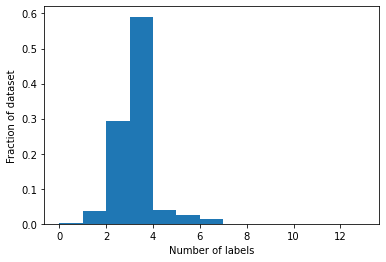

In [243]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over less than 1/10 of our `train` dataset data points have 0 or fewer labels from LFs. The labels we do have can be used to train a classifier over the comment text directly, allowing this final machine learning model to generalize beyond what our labeling functions labeling.

Our goal is now to convert the labels from our LFs into a single noise-aware probabilistic (or confidence-weighted) label per data point. 

A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted MOTION than NOT_MOTION, label it MOTION (and vice versa). We can test this with the `MajorityLabelVoter` baseline model.

In [244]:
majority_model = MajorityLabelVoter()
preds_train_majority_model = majority_model.predict(L=L_train)

In [245]:
label_model = LabelModel(cardinality=2, device='cpu', verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=1.101]
INFO:root:[100 epochs]: TRAIN:[loss=0.012]
INFO:root:[200 epochs]: TRAIN:[loss=0.012]
 44%|████▎     | 218/500 [00:00<00:00, 2176.93epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.012]
INFO:root:[400 epochs]: TRAIN:[loss=0.012]
100%|██████████| 500/500 [00:00<00:00, 2420.06epoch/s]
INFO:root:Finished Training


In [246]:
preds_train_label_model = label_model.predict(L=L_train)

**Train accuracy**

In [247]:
majority_acc = majority_model.score(L=L_train, Y=df_train.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_train, Y=df_train.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   97.9%
Label Model Accuracy:     93.4%


**Val accuracy**

In [248]:
majority_acc = majority_model.score(L=L_val, Y=df_val.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_val, Y=df_val.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   98.1%
Label Model Accuracy:     94.0%


**Test accuracy**

In [249]:
majority_acc = majority_model.score(L=L_test, Y=df_test.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=df_test.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   97.4%
Label Model Accuracy:     93.0%


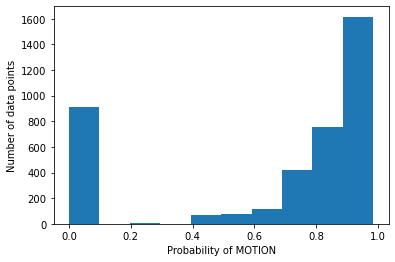

In [251]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of MOTION")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, MOTION])

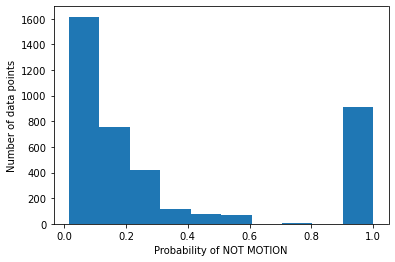

In [252]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of NOT MOTION")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, NOT_MOTION])

In [259]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [260]:
df_train_filtered

,docket_entry_id,motion,text
5418,13765,1,"Joint MOTION for Attorney Fees by Defendant Commissioner of Social Security. (Attachments: # 1 Exhibit Proposed Order)(Neltner, Andrew) (Entered: 06/06/2018)"
6298,11928,1,"MOTION to Continue Trial by Carlos Maez. (Lenyo, Mark) (Entered: 01/16/2018)"
5352,9878,1,"MOTION by Defendant ValuePart, Inc. for reconsideration regarding order on motion to strike, order on motion to dismiss, order on motion to transfer case, terminate hearings, motion hearing,,,,,,,,,, 39 Motion to Reconsider the Denial of Defendant's Motion to Transfer to Magistrate Judge Keys (Attachments: # 1 Exhibit)(McIntyre, Maura) (Entered: 05/07/2010)"
1397,7325,1,"MOTION by Defendant Amazon.Com, Inc. for extension of time to file answer regarding amended complaint 9 (Balfour, Ronald) (Entered: 03/02/2017)"
5062,7000,1,"MOTION by James M Vani for judgment of acquittal (Beal, John) (Entered: 04/26/2014)"
...,...,...,...
2141,11323,1,"Joint MOTION for Extension of Time to File Response/Reply as to 46 MOTION for Summary Judgment , 48 RULE 56 MOTION to Strike (Motion to Exclude Expert Opinions of Trevor Suslow), 44 MOTION for Summary Judgment by Counter Defendant Keystone Logistics Inc, Plaintiff Keystone Logistics Inc. (Fullenkamp, Joseph) (Entered: 01/10/2018)"
6922,2446,1,"MOTION by Defendants Clay, Cook County, Salvador Godinez, Jones, Morrison, Price to substitute attorney Kevin Frey, MOTION by counsel for Defendants Clay, Cook County, Salvador Godinez, Jones, Morrison, Price to withdraw as attorney Patrick Smith (Smith, Patrick) (Entered: 07/22/2011)"
2294,14156,1,"MOTION for Extension of Time to File Response/Reply as to 98 MOTION for Attorney Fees by Defendants Parkview Health System Inc, Parkview Hospital Inc, Roy Robertson. (Hardman, Lyle) (Entered: 05/30/2019)"
3532,9476,1,"MOTION by Defendant City Of Chicago to dismiss Under Rule 12(B)(6) (Schaller, Rachel) (Entered: 08/17/2018)"


In [261]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

In [262]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [263]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, solver='liblinear')

In [264]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=df_test.motion) * 100:.1f}%")

Test Accuracy: 92.8%
